In [1]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.nn as pyg_nn

In [2]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [6]:
# Define the network architecture
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
#         x = torch.dropout(x, p=0.5, training=self.training)
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)

        return torch.log_softmax(x, dim=1)

In [17]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model, optimizer and loss function
model = GNN(dataset.num_node_features, 16, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Testing the model
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8070


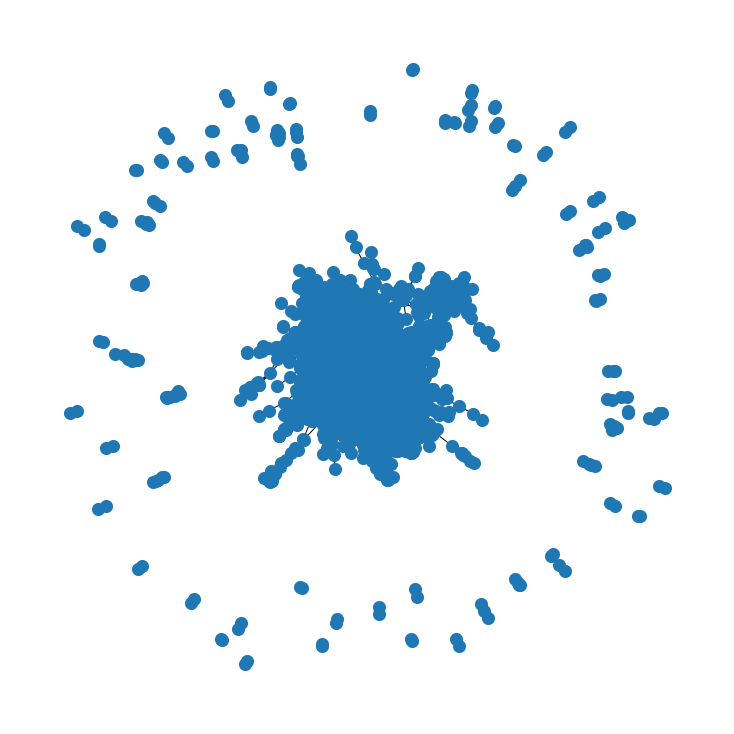

In [10]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
# 加载Cora数据集
data = dataset[0]

# 将PyG图转换为networkx图
G = to_networkx(data, to_undirected=True)

# 绘制图
plt.figure(figsize=(10,10))
nx.draw(G, node_size=50, linewidths=6)
plt.show()

In [11]:
G.number_of_nodes()

2708

In [12]:
dataset.num_node_features

1433

In [18]:
import torch
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class STConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(STConv, self).__init__(aggr='mean')  # "Mean" aggregation.
        self.lin = Sequential(Linear(in_channels, out_channels),
                              ReLU(), Linear(out_channels, out_channels))
        
    def forward(self, x, edge_index):
        # x has shape [N, T, in_channels]
        # edge_index has shape [2, E]

        # Start propagating messages.
        return self.propagate(edge_index, x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, T, in_channels]
        
        # Temporal convolution
        x_j = self.lin(x_j)

        return x_j

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Number of nodes in the graph
num_nodes = 4

# Number of features per node
num_features = 2

# Number of time steps
num_timesteps = 3

# Randomly generate node features for each time step
x = torch.randn(num_timesteps, num_nodes, num_features)

# Randomly generate edges
edge_index = torch.randint(num_nodes, (2, num_nodes))

# Create a PyTorch Geometric Data object for the graph
data = Data(x=x, edge_index=edge_index)

class STGCN(torch.nn.Module):
    def __init__(self):
        super(STGCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = STGCN()

# Forward pass
out = model(data)
print(out)


tensor([[[-0.6375,  0.2180],
         [-0.3956,  0.4593],
         [-0.5298,  0.2028],
         [-0.5334,  0.5477]],

        [[-0.6203,  0.6048],
         [-0.6456,  0.5627],
         [-0.4616,  0.4044],
         [-0.8162,  0.7395]],

        [[ 0.1007, -0.4388],
         [ 0.0174, -0.4252],
         [ 0.1850, -0.4526],
         [ 0.0819, -0.5702]]], grad_fn=<AddBackward0>)
